<a href="https://colab.research.google.com/github/miles-garcia/DSPS_MGarcia/blob/main/DSPS2023_autoencoders_8dec23_students_MGarcia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from copy import deepcopy

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from scipy.signal import convolve2d

from tensorflow import keras
from keras.datasets import mnist
from keras import layers

!pip install icecream
from icecream import ic

rng = np.random.RandomState(1415)

# Load MNIST data

In [ ]:
# Load the data and split it between train and test sets
(Xtrn, Ytrn), (Xtst, Ytst) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


# Visualize dataset

In [ ]:
Xtst.shape

(10000, 28, 28)

In [ ]:
def plot_img(images,labels,nrows=5,ncols=5,vmin=0,vmax=255):
  fig,axes = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(8,8))
  for i in range(nrows*ncols):
    ax = axes.flatten()[i]
    image = images[i]
    label = labels[i]
    ax.set_title(label)
    ax.imshow(image,vmin=vmin,vmax=vmax,cmap='Greys')
    ax.set_aspect("equal")
    ax.axis("off")
  fig.tight_layout()
  fig.show()

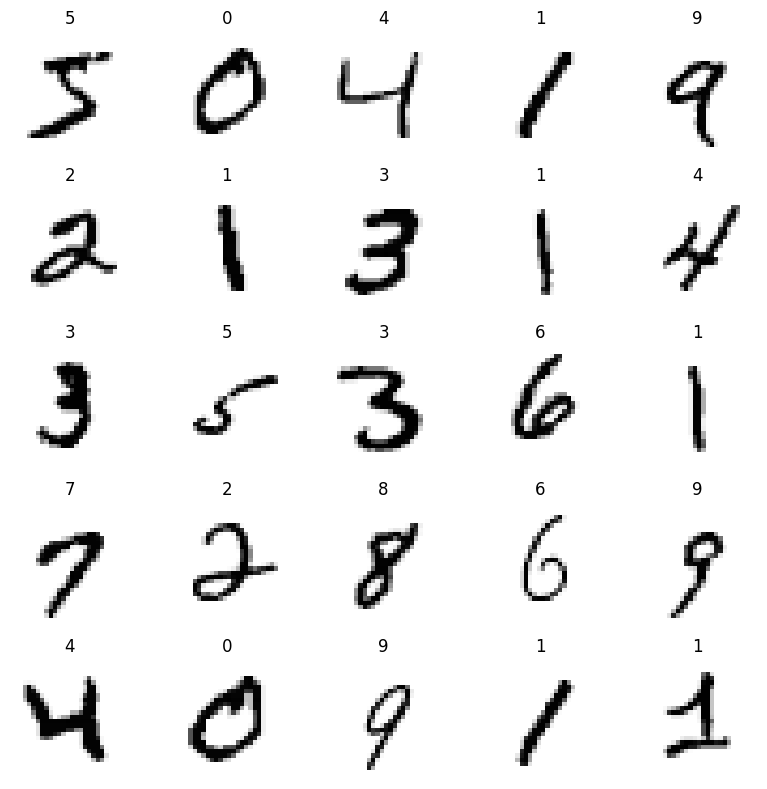

In [ ]:
plot_img(Xtrn,Ytrn)

# Normalize the images

In [ ]:
def norm_255(array):
  normed_array = array/255
  return normed_array

In [ ]:
XtrnN = norm_255(Xtrn)
XtstN = norm_255(Xtst)

In [ ]:
XtrnN.max()

1.0

# Reshape the arrays for Keras

In [ ]:
def reshape_keras(array):
  reshaped_array = array[...,None]
  return reshaped_array


In [ ]:
XtrnNR = reshape_keras(XtrnN)
XtstNR = reshape_keras(XtstN)

In [ ]:
XtrnNR.shape

(60000, 28, 28, 1)

# One-hot encode the image labels

# But wait we don't need the image labels...

### The training set will be the images at half resolution, and the model will try to up-sample the images to the original resolution... `Xtrn` should be the same 60,000 images at half resolution, but `Ytrn` should be those same images at the original resolution. We will do the same operations for the testing set.

# Construct dataset for superresolution, not image classification

In [ ]:
def resolution(X):
  Xnew = deepcopy(X)[:,::2,::2,:]
  Ynew = deepcopy(X)
  return Xnew,Ynew

In [ ]:
XtrnSR, YtrnSR = resolution(XtrnNR)
XtstSR, YtstSR = resolution(XtstNR)

In [ ]:
XtrnSR.shape, YtrnSR.shape, XtstSR.shape, YtstSR.shape

((60000, 14, 14, 1),
 (60000, 28, 28, 1),
 (10000, 14, 14, 1),
 (10000, 28, 28, 1))

# Visualize the new dataset

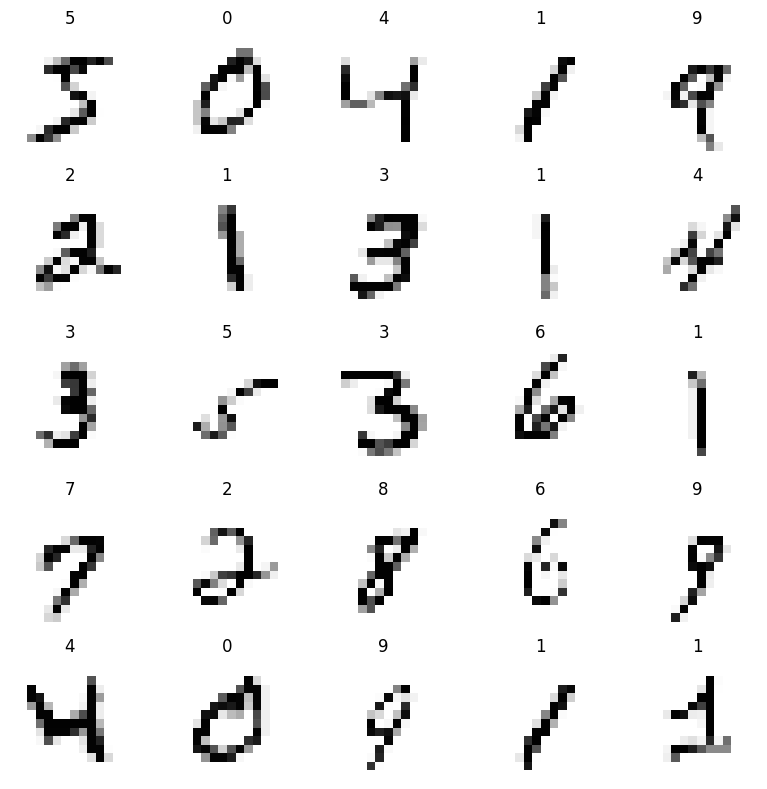

In [ ]:
plot_img(XtrnSR[:,:,:,0],Ytrn,vmin=0,vmax=1)

In [ ]:
XtrnSR[:,:,:,0].shape

(60000, 14, 14)

In [ ]:
Xtrn.shape

(60000, 28, 28)

# Build the CNN autoencoder

In [ ]:
def build_aenc(input_shape):
  inputs = layers.Input(shape=input_shape)
  x = layers.Conv2D(16,kernel_size=  (3,3),padding = "same",activation = "relu")(inputs)
  x = layers.Conv2D(8,kernel_size=  (3,3),padding = "same",activation = "relu")(x)
  x = layers.Conv2D(4,kernel_size=  (3,3),padding = "same",activation = "relu")(x)
  x = layers.MaxPooling2D(pool_size = (2,2))(x)

  shape = x.shape
  n_neurons = shape[1] * shape[2] * shape [3]

  x = layers.Flatten()(x)
  LS = layers.Dense(16,activation = "relu")(x)
  x = layers.Dense(n_neurons,activation="relu")(LS)
  x= layers.Reshape(shape[1:])(x)

  x=layers.Conv2DTranspose(4,kernel_size=(3,3), padding = "same", activation = "relu")(x)
  x=layers.Conv2DTranspose(8,kernel_size=(3,3), padding = "same", activation = "relu")(x)
  x=layers.Conv2DTranspose(16,kernel_size=(3,3), padding = "same", activation = "relu")(x)
  x = layers.UpSampling2D(size=(2,2))(x)

  x = layers.Conv2DTranspose(16,kernel_size=(3,3), padding = "same", activation = "relu")(x)
  x = layers.Conv2DTranspose(16,kernel_size=(3,3), padding = "same", activation = "relu")(x)
  x = layers.Conv2DTranspose(16,kernel_size=(3,3), padding = "same", activation = "relu")(x)
  x = layers.UpSampling2D(size=(2,2))(x)

  x = layers.Conv2DTranspose(16,kernel_size=(3,3), padding = "same", activation = "sigmoid")(x)
  x = layers.Conv2DTranspose(16,kernel_size=(3,3), padding = "same", activation = "sigmoid")(x)
  outputs = layers.Conv2DTranspose(1,kernel_size=(3,3), padding = "same", activation = "sigmoid")(x)


  model = keras.Model(inputs,outputs)

  encoder = keras.Model(inputs,LS)
  decoder = keras.Model(LS,outputs)



  return model,encoder,decoder

In [ ]:
input_shape = XtrnSR.shape[1:]

In [ ]:
model,encoder,decoder = build_aenc(input_shape)

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 14, 14, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 4)         292       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 4)           0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 196)               0         
                                                           

# Train the model (use a GPU)

In [ ]:
model.compile(loss="mse",optimizer="adam")
hist = model.fit(XtrnSR,YtrnSR,batch_size=256, epochs = 15,validation_split = 0.1)

Epoch 1/15
211/211 [==============================] - 21s 17ms/step - loss: 0.1049 - val_loss: 0.0655
Epoch 2/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0460 - val_loss: 0.0328
Epoch 3/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0290 - val_loss: 0.0257
Epoch 4/15
211/211 [==============================] - 3s 14ms/step - loss: 0.0249 - val_loss: 0.0246
Epoch 5/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0229 - val_loss: 0.0220
Epoch 6/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0217 - val_loss: 0.0210
Epoch 7/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0209 - val_loss: 0.0206
Epoch 8/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0202 - val_loss: 0.0197
Epoch 9/15
211/211 [==============================] - 4s 21ms/step - loss: 0.0197 - val_loss: 0.0193
Epoch 10/15
211/211 [==============================] - 4s 18ms/step - loss: 0.0193 - val_l

# Visualize loss curve

# Visualize the predictions

In [ ]:
PtstSR = model.predict(XtstSR)
PtstSR.shape

313/313 [==============================] - 2s 4ms/step


(10000, 28, 28, 1)

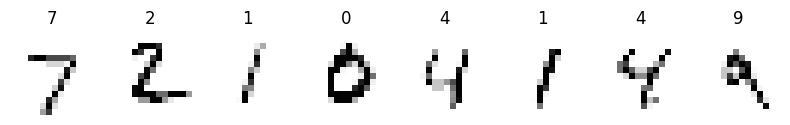

In [ ]:
plot_img(XtstSR[...,0],Ytst,nrows=1,ncols=8,vmax=1)

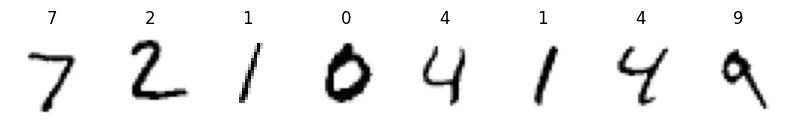

In [ ]:
plot_img(YtstSR[...,0],Ytst,nrows=1,ncols=8,vmax=1)

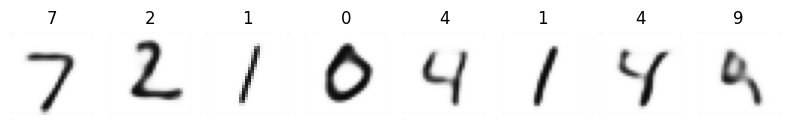

In [ ]:
plot_img(PtstSR[...,0],Ytst,nrows=1,ncols=8,vmax=1)

# Visualize the early layers

In [ ]:
model.layers[1].get_weights()[0].shape

(3, 3, 1, 16)

# Visualize the latent space with the encoder and decoder on their own

# Find the average latent space representation for each digit

# Decode latent space representations with the decoder

# What if we input something in the latent space by hand and then decode it?